<a href="https://colab.research.google.com/github/BrenoMilagres/AnalisesGit/blob/master/regress%C3%A3oAlugueisBicicletas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizando regressão para prever a quantidade de bicicletas alugadas.
- Análise exploratória 
- Pré-processamento
- Correlação
- Separando dados de entrada e saída 
- Validação cruzada 
- Treinando o algoritmo e gerando o modelo de regressão
- Testando os resultados
- Ajustando os hiperparametros


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files  #biblioteca utilizada para carregar os dados para o google colab
uploaded = files.upload()

Saving bike_rental_hour.csv to bike_rental_hour.csv


In [3]:
bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#Entendendo a base de dados:
- instant: índice de registro
- dteday: data do aluguel (ano-mês-dia)
- season: estação (1: inverno, 2: primavera, 3: verão, 4: outono)
- yr: ano (0: 2011, 1: 2012)
- mnth: mês (1 a 12)
- hr: hora (0 a 23)
- holiday: o dia com clima é feriado ou não (extraído de [Web Link])
- weekday: dia da semana
- workingday: se o dia não for final de semana nem feriado, for 1, caso contrário será 0 – equivalente ao dia útil.
- weathersit: tempo
 - 1: limpo, poucas nuvens, parcialmente nublado, parcialmente nublado
 - 2: névoa + nublado, névoa + nuvens partidas, névoa + poucas nuvens, névoa
 - 3: neve fraca, chuva fraca + trovoada + nuvens dispersas, chuva fraca + nuvens dispersas
 - 4: chuva forte + paletes de gelo + trovoada + névoa, neve + nevoeiro
- temp: temperatura normalizada em graus Celsius. Os valores são derivados de (t-t_min) / (t_max-t_min), t_min = -8, t_max = + 39 (apenas na escala horária)
- atemp: temperatura normal de sensação em graus Celsius. Os valores são derivados de (t-t_min) / (t_max-t_min), t_min = -16, t_max = + 50 (apenas na escala horária)
- hum: umidade normalizada. Os valores são divididos em 100 (máximo)
- windspeed: velocidade do vento normalizada. Os valores são divididos em 67 (máximo)
- casual: número de usuários casuais
- registered: número de usuários registrados
- cnt: contagem do total de bicicletas alugadas, incluindo bicicletas casuais e registradas (variável target)

In [4]:
bike_rentals.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


#  Distribuição do atributo 'cnt':

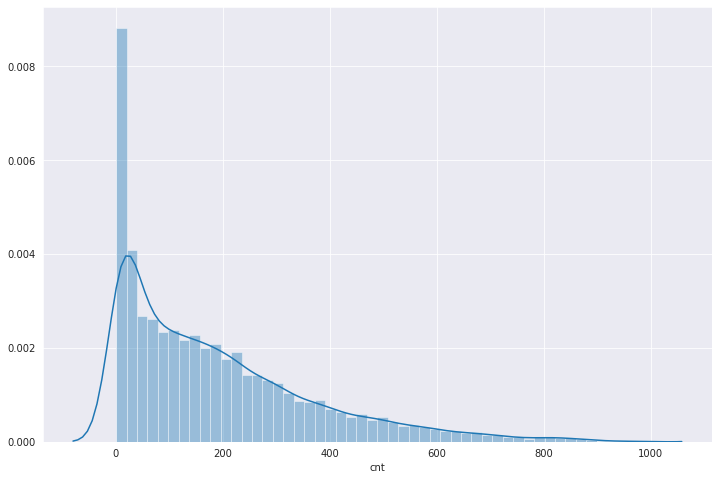

In [5]:
plt.figure(figsize=(12,8))
sns.set_style('darkgrid')
sns.distplot(bike_rentals.cnt)

# Avaliando correlação entre as variáveis 

In [6]:
bike_rentals.corr()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
season,0.404046,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.136178,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772


In [7]:
correlations = bike_rentals.corr()
correlations['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

# Separando dados de entrada para regressão 

In [8]:
columns = bike_rentals.columns.drop(['cnt', 'casual', 'dteday', 'registered'])
columns

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')

# Separando os dados de treino e teste:

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bike_rentals[columns],bike_rentals['cnt'], test_size=0.20, random_state=42)

# Instanciando e gerando o algoritmo:

In [11]:
lr = LinearRegression()
model = lr.fit(X_train,y_train)

#Realizando a predição
resultado = model.predict(X_test)

In [12]:
#erro médio quadrático
mean_squared_error(y_test, resultado)

19376.952766955474

In [13]:
#computando Score
model.score(X_test,y_test)

0.3880719703569244

In [15]:
#Comparando os resultados aplicando os dados de treinamento:
resultado_treino = model.predict(X_train)
mean_squared_error(y_train, resultado_treino)

20292.141009176416

In [16]:
model.score(X_train,y_train)

0.3888263676964571

*Nesse primeiro modelo temos um erro muito alto e um valor de score muito baixo, esses resultados são  pouco satisfatórios.*

# Árvore de Decisão

In [17]:
tree = DecisionTreeRegressor()

In [18]:
model_tree = tree.fit(X_train,y_train)
resultado_tree = tree.predict(X_test)

In [19]:
mean_squared_error(y_test, resultado_tree)

3481.552359033372

In [20]:
model_tree.score(X_test,y_test)

0.8900518827296893

*Note que os resultados são melhores, e já conseguimos cumprir o objetivo de diminuir o valor do erro e ter um score mais alto*

# Random Forest

In [21]:
tree_rf = RandomForestRegressor()

In [23]:
model_rf = tree_rf.fit(X_train, y_train)
resultado_rf = model_rf.predict(X_test)

In [24]:
mean_squared_error(y_test, resultado_rf)

1664.6231870253164

In [25]:
model_rf.score(X_test,y_test)

0.9474308680427966

*Random forest apresenta melhor desempenho de acordo com as métricas*

# Ajustando os hiperparametros do Random Forest

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
parametros = {'min_samples_leaf':[1,10],'min_samples_split':[2,10],'n_estimators':[100,250,500,750]}

In [28]:
rf = RandomForestRegressor()
grid = GridSearchCV(rf, parametros)

In [29]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [30]:
grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

In [31]:
rf_best = grid.best_estimator_

In [32]:
resultado_final = rf_best.predict(X_test)

In [33]:
mean_squared_error(y_test, resultado_final)

1633.150235598389

In [34]:
rf_best.score(X_test,y_test)

0.9484247901205021

*Através da otimização dos hiperparametros foi possivel melhorar os resultados*